<a href="https://colab.research.google.com/github/RuthKassahun/Brain_Tissue_Segmentation/blob/main/2D_unet_MISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import cv2
import glob
import warnings
import scipy.misc
!pip install simpleitk
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D,UpSampling2D,concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
FNAME_PATTERN = '/content/drive/MyDrive/MISA_Final_project/IBSR-{}-{}.nii'
N_VOLUMES = 15
IMAGE_SIZE = (256, 128, 256)

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)

# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
VALIDATION_VOLUMES = [10, 11, 12, 13, 14]
#TEST_VOLUMES = [14]


# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 10
BATCH_SIZE = 64
PATIENCE = 20
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
#LOSS ='sparse_categorical_crossentropy'
#LOSS = tfa.losses.GIoULoss()

dropout_rate = 0.40

In [ ]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the UNet (32-64-128-256-512)
    conv1   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    drop1   = Dropout(rate=dropout_rate)(conv1, training=True)
    max1    = MaxPooling2D((2, 2))(drop1)

    conv2   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2   = Dropout(rate=dropout_rate)(conv2, training=True)
    max2    = MaxPooling2D((2, 2))(drop2)

    conv3   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3   = Dropout(rate=dropout_rate)(conv3, training=True)
    max3    = MaxPooling2D((2, 2))(drop3)

    conv4   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4   = Dropout(rate=dropout_rate)(conv4, training=True)
    max4    = MaxPooling2D((2, 2))(drop4)

    lat     = Conv2D(512*scale, (3, 3), padding="same", activation='relu')(max4)
    drop5   = Dropout(rate=dropout_rate)(lat, training=True)

    # Decoding Path of the UNet
    up1     = UpSampling2D((2, 2))(drop5)
    concat1 = concatenate([conv4, up1], axis=-1)
    conv5   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop6   = Dropout(rate=dropout_rate)(conv5, training=True)
    
    up2     = UpSampling2D((2, 2))(drop6)
    concat2 = concatenate([conv3, up2], axis=-1)
    conv6   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop7   = Dropout(rate=dropout_rate)(conv6, training=True)
    
    up3     = UpSampling2D((2, 2))(drop7)
    concat3 = concatenate([conv2, up3], axis=-1)
    conv7   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop8   = Dropout(rate=dropout_rate)(conv7, training=True)

    up4     = UpSampling2D((2, 2))(drop8)
    concat4 = concatenate([conv1, up4], axis=-1)
    conv8   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)
    drop9   = Dropout(rate=dropout_rate)(conv8, training=True)
    
    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(drop9)

    model   = keras.Model(inputs, outputs)

    return model

In [ ]:
def load_data(n_volumes=N_VOLUMES, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  #T2_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  for i in range(n_volumes) :
    img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    T1_volumes[i] = img_data.get_fdata()

    # img_data = nib.load(fname_pattern.format(i+1, 'T2'))
    # T2_volumes[i] = img_data.get_fdata()

    seg_data = nib.load(fname_pattern.format(i+1, 'label'))
    labels[i] = seg_data.get_fdata()

  return (T1_volumes, labels)

In [ ]:
(T1_volumes, labels) = load_data()

In [ ]:
training_volumes_T1 = T1_volumes[TRAINING_VOLUMES]
#training_volumes_T2 = T2_volumes[TRAINING_VOLUMES]
training_labels = labels[TRAINING_VOLUMES]

validation_volumes_T1 = T1_volumes[VALIDATION_VOLUMES]
#validation_volumes_T2 = T2_volumes[VALIDATION_VOLUMES]
validation_labels = labels[VALIDATION_VOLUMES]

#testing_volumes_T1 = T1_volumes[TEST_VOLUMES]
#testing_volumes_T2 = T2_volumes[TEST_VOLUMES]
#testing_labels = labels[TEST_VOLUMES]

In [ ]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])


  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')
  
  return (vol_patches, seg_patches)

In [ ]:
# extract patches from training set
(training_patches_T1, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)
#(training_patches_T2, _) = extract_useful_patches(training_volumes_T2, training_labels)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)
#(validation_patches_T2, _) = extract_useful_patches(validation_volumes_T2, validation_labels)

In [ ]:
unet = get_unet()

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
]

unet = get_unet()
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.fit(
    x=training_patches_T1, 
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/10
200/200 [==============================] - 9s 32ms/step - loss: 0.7596 - val_loss: 0.5528
Epoch 2/10
200/200 [==============================] - 5s 27ms/step - loss: 0.4304 - val_loss: 0.4591
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.3563 - val_loss: 0.4012
Epoch 4/10
200/200 [==============================] - 6s 28ms/step - loss: 0.3133 - val_loss: 0.4080
Epoch 5/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2844 - val_loss: 0.3873
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2641 - val_loss: 0.3844
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2484 - val_loss: 0.4004
Epoch 8/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2351 - val_loss: 0.3468
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2234 - val_loss: 0.3663
Epoch 10/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2166 - val_lo

In [ ]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.load_weights('model.h5')

In [ ]:
# testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
# testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]])

In [ ]:
validation_volumes_T1_processed = validation_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
validation_labels_processed = validation_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]])

In [ ]:
def pred_val_data(validation_volumes_T1_processed)  :
  # creates probability map of each label for all volumes
  #prediction = unet.predict(x=testing_volumes_processed)
  prediction = unet.predict(x=validation_volumes_T1_processed)

  prediction = np.argmax(prediction, axis=3)

  plt.axis('off')
  plt.imshow(prediction[:, :, 150])

  return prediction

40/40 [==============================] - 5s 85ms/step


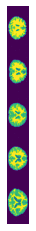

In [ ]:
prediction = pred_val_data(validation_volumes_T1_processed)

In [ ]:
!pip install medpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.4.0-cp38-cp38-linux_x86_64.whl size=753426 sha256=1cb519b3def1fc8779e5540fcc25069743e2d524da4a5040be82e66cf2e4cee4
  Stored in directory: /root/.cache/pip/wheels/fc/38/7d/e0b8bcb2770f779a93cab5ab7fa6dd344011e1278cb90cab86
Successfully built medpy


In [ ]:
import numpy as np
import nibabel as nib
from medpy.metric.binary import dc, hd, ravd

def compute_dice(prediction, reference) :
  for c in np.unique(prediction) :
    dsc_val = dc(prediction == c, reference==c)
    print(f'Dice coefficient class {c} equal to {dsc_val : .2f}')

def compute_hd(prediction, reference, voxel_spacing) :
  for c in np.unique(prediction) :
    hd_val = hd(prediction == c, reference==c, voxelspacing=voxel_spacing, connectivity=1)
    print(f'Hausdorff distance class {c} equal to {hd_val : .2f}')

def compute_ravd(prediction, reference) :
  for c in np.unique(prediction) :
    ravd_val = ravd(prediction == c, reference==c)
    print(f'Dice coefficient class {c} avd {ravd_val : .2f}')

compute_dice(prediction, validation_labels_processed)
compute_hd(prediction, validation_labels_processed, [1, 1, 1])
compute_ravd(prediction, validation_labels_processed)

Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.69
Dice coefficient class 2 equal to  0.89
Dice coefficient class 3 equal to  0.85
Hausdorff distance class 0 equal to  62.18
Hausdorff distance class 1 equal to  150.35
Hausdorff distance class 2 equal to  122.90
Hausdorff distance class 3 equal to  120.22
Dice coefficient class 0 avd  0.00
Dice coefficient class 1 avd -0.04
Dice coefficient class 2 avd  0.04
Dice coefficient class 3 avd -0.10


8/8 [==============================] - 1s 89ms/step
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.62
Dice coefficient class 2 equal to  0.86
Dice coefficient class 3 equal to  0.89
Hausdorff distance class 0 equal to  47.47
Hausdorff distance class 1 equal to  150.48
Hausdorff distance class 2 equal to  124.02
Hausdorff distance class 3 equal to  113.28
Dice coefficient class 0 avd  0.00
Dice coefficient class 1 avd  0.35
Dice coefficient class 2 avd -0.14
Dice coefficient class 3 avd  0.15
8/8 [==============================] - 1s 93ms/step
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.69
Dice coefficient class 2 equal to  0.88
Dice coefficient class 3 equal to  0.87
Hausdorff distance class 0 equal to  46.00
Hausdorff distance class 1 equal to  150.11
Hausdorff distance class 2 equal to  115.33
Hausdorff distance class 3 equal to  119.26
Dice coefficient class 0 avd  0.00
Dice coefficient class 1 avd -0.15
Dice coefficient

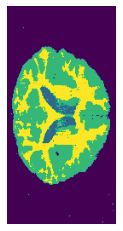

In [ ]:
import numpy as np
import nibabel as nib
from medpy.metric.binary import dc, hd, ravd

def compute_dice(prediction, reference) :
  dice_scores = np.zeros((1,4))
  for c in np.unique(prediction) :
    dsc_val = dc(prediction == c, reference==c)
    dice_scores[0,c] = dsc_val
    print(f'Dice coefficient class {c} equal to {dsc_val : .2f}')
  return dice_scores

def compute_hd(prediction, reference, voxel_spacing) :
  hd_scores = np.zeros((1,4))
  for c in np.unique(prediction) :
    hd_val = hd(prediction == c, reference==c, voxelspacing=voxel_spacing, connectivity=1)
    hd_scores[0,c] = hd_val
    print(f'Hausdorff distance class {c} equal to {hd_val : .2f}')
  return hd_scores

def compute_ravd(prediction, reference) :
  ravd_scores = np.zeros((1,4))
  for c in np.unique(prediction) :
    ravd_val = ravd(prediction == c, reference==c)
    ravd_scores[0,c] = ravd_val
    print(f'Dice coefficient class {c} avd {ravd_val : .2f}')
  return ravd_scores

# compute_dice(prediction, testing_labels_processed)
# compute_hd(prediction, testing_labels_processed, [1, 1, 1])
# compute_ravd(prediction, testing_labels_processed)

dice_list=np.zeros((len(validation_volumes_T1),4))
hd_list=np.zeros((len(validation_volumes_T1),4))
ravd_list=np.zeros((len(validation_volumes_T1),4))

for i in range(0,len(validation_volumes_T1)):

  testing_volumes_T1=validation_volumes_T1[i]
  testing_labels=validation_labels[i]
  testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
  testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]])
  prediction = pred_val_data(testing_volumes_T1_processed)

  dice_list[i,:] = compute_dice(prediction, testing_labels_processed)
  hd_list[i,:] = compute_hd(prediction, testing_labels_processed, [1, 1, 1])
  ravd_list[i,:] = compute_ravd(prediction, testing_labels_processed)

dice_total=dice_list.sum(axis=0)
hd_total=hd_list.sum(axis=0)
ravd_total=ravd_list.sum(axis=0)

for i in range(0,4):
  print("Average Dice, HD, and RAVD for class {} is {},{}, and {}".format(i,dice_total[i]/len(validation_volumes_T1),hd_total[i]/len(validation_volumes_T1),ravd_total[i]/len(validation_volumes_T1)))

In [ ]:
dice_list

array([[0.99635013, 0.61780768, 0.86157093, 0.88840287],
       [0.99592298, 0.68891504, 0.88332213, 0.86617104],
       [0.99592611, 0.61460003, 0.89816029, 0.82207686],
       [0.99700104, 0.73635582, 0.90716153, 0.86315123],
       [0.99535492, 0.76304195, 0.90004591, 0.82523064]])

In [ ]:
hd_list


array([[ 47.46577715, 150.48255713, 124.02015965, 113.27841807],
       [ 46.        , 150.10662877, 115.32562595, 119.2560271 ],
       [ 45.        , 151.84531603, 116.03447763, 123.47064428],
       [ 44.        , 149.45567905, 114.41590798, 123.38557452],
       [ 42.59107888, 144.26018162, 108.77499713, 103.77379245]])

In [ ]:
ravd_list

array([[ 1.86847913e-03,  3.52229359e-01, -1.38275232e-01,
         1.54573723e-01],
       [ 1.69915137e-03, -1.50056065e-01,  3.86732733e-02,
        -1.12344403e-01],
       [ 2.21616817e-03, -1.36236082e-01,  4.60341596e-02,
        -1.70899942e-01],
       [-1.39542004e-03,  1.45732631e-02,  1.03012934e-01,
        -1.66231080e-01],
       [-3.23683621e-04, -1.09183838e-01,  9.07270249e-02,
        -1.87032312e-01]])

In [ ]:
for i in range(0,4):
  print("Average Dice, HD, and RAVD for class {} is {},{}, and {}".format(i,dice_total[i]/len(validation_volumes_T1),hd_total[i]/len(validation_volumes_T1),ravd_total[i]/len(validation_volumes_T1)))

Average Dice, HD, and RAVD for class 0 is 0.9961110347805697,45.0113712046634, and 0.0008129390008609265
Average Dice, HD, and RAVD for class 1 is 0.6841441031995,149.2300725182011, and -0.005734672613315078
Average Dice, HD, and RAVD for class 2 is 0.8900521576883854,115.71423366902279, and 0.02803443202553458
Average Dice, HD, and RAVD for class 3 is 0.8530065287866213,116.63289128558192, and -0.09638680273874753
